In [1]:
import get_combine_data
import pandas as pd
import numpy as np
import altair as alt

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.11) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


just get data for one position. clean data frame with only the quantile measurements.

In [2]:
all_data = get_combine_data.get_data(drafted_only=True)

all_data.head()

on position P, can't do metric Vertical
on position K, can't do metric Vertical
on position QB, can't do metric Bench
on position P, can't do metric Bench
on position K, can't do metric Bench
on position P, can't do metric Broad Jump
on position K, can't do metric Broad Jump
on position P, can't do metric 3Cone
on position K, can't do metric 3Cone
on position P, can't do metric Shuttle
on position K, can't do metric Shuttle


,Player,Pos,School,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,...,q_Broad Jump,q_3Cone,q_Shuttle,pos_d_40yd,pos_d_Vertical,pos_d_Bench,pos_d_Broad Jump,pos_d_3Cone,pos_d_Shuttle,composite_score
0,John Abraham,OLB,South Carolina,6-4,252.0,4.55,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,8.000000
1,Shaun Alexander,RB,Alabama,6-0,218.0,4.58,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.000000
2,Darnell Alford,OT,Boston Col.,6-4,334.0,5.56,25.0,23.0,94.0,8.48,...,1.0,0.0,2.0,0.0,1.0,3.0,0.0,0.0,0.0,0.666667
4,Rashard Anderson,CB,Jackson State,6-2,206.0,4.55,34.0,NaN,123.0,7.18,...,78.0,47.0,78.0,1.0,1.0,NaN,5.0,1.0,4.0,2.400000
6,LaVar Arrington,OLB,Penn State,6-3,250.0,4.53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,8.000000


In [49]:
quantile_cols = all_data.columns[all_data.columns.str.startswith("q_")]
#quantile_cols = quantile_cols.append("Player") # might want their names

quantile_cols = list(quantile_cols)

quantile_cols.sort()

In [50]:
running_backs = all_data[all_data.Pos == "RB"]

quantile_data = running_backs.loc[:, quantile_cols]

quantile_data.head()

,q_3Cone,q_40yd,q_Bench,q_Broad Jump,q_Shuttle,q_Vertical
1,NaN,62.0,NaN,NaN,NaN,NaN
41,NaN,92.0,28.0,NaN,NaN,NaN
48,86.0,65.0,18.0,92.0,70.0,88.0
77,NaN,51.0,NaN,NaN,NaN,NaN
81,35.0,50.0,7.0,42.0,37.0,20.0


ok, so I really like the look of this ridgeline plot: https://altair-viz.github.io/gallery/ridgeline_plot.html

but I'm getting impedence fitting my data into the format it wants. so I'll start simple.  taken from: https://altair-viz.github.io/gallery/density_facet.html


In [ ]:
import altair as alt
from vega_datasets import data

source = data.iris()

alt.Chart(source).transform_fold(
    ['petalWidth',
     'petalLength',
     'sepalWidth',
     'sepalLength'],
    as_ = ['Measurement_type', 'value']
).transform_density(
    density='value',
    bandwidth=0.3,
    groupby=['Measurement_type'],
    extent= [0, 8]
).mark_area().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('Measurement_type:N')
).properties(width=300, height=50)

In [85]:
source = quantile_data

scale = alt.Scale(scheme='lightgreyred', domainMid=50)

alt.Chart(source).transform_fold(
    list(quantile_cols),
    as_ = ['Measurement_type', 'value']
).transform_density(
    density='value',
    groupby=['Measurement_type'],
    counts=True,
    extent= [0, 100]
).transform_joinaggregate(
    groupby=['Measurement_type'],
    meas_mean='mean(value)',
    meas_count='count(value)',
    meas_sum='sum(value)'
).mark_area(
    interpolate='monotone',
    fillOpacity=0.8,
    stroke='lightgray',
    strokeWidth=0.5
).encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Fill('meas_mean:Q', scale=scale),
    alt.Row('Measurement_type:N')
).encode(
    tooltip=["meas_mean:Q", "meas_count:Q", "meas_sum:Q"]
).properties(width=300, height=50)

alt.Chart(...)

yeah, so the problem is that the means it's calculating are total nonsense, and I don't know where they're coming from.


the "joinaggregate" clause has to come after the "transform_density"

In [76]:
quantile_data.sum()

q_3Cone         13222.0
q_40yd          25441.0
q_Bench         11354.0
q_Broad Jump    18011.0
q_Shuttle       13009.0
q_Vertical      17720.0
dtype: float64

I think this might be a more friendly format for using with altair.

In [95]:
fool = quantile_data.reset_index(drop=True).unstack().reset_index(name='value').drop("level_1", axis=1).dropna()
#.drop_index().unstack().reset_index()

fool

,level_0,value
2,q_3Cone,86.0
4,q_3Cone,35.0
5,q_3Cone,72.0
7,q_3Cone,87.0
9,q_3Cone,81.0
...,...,...
2137,q_Vertical,47.0
2138,q_Vertical,66.0
2139,q_Vertical,71.0
2140,q_Vertical,75.0


well OK, this is ugly AF, but it at least appears to be accurate.

In [96]:
alt.Chart(fool).transform_density(
    density='value',
    groupby=['level_0']
).mark_area().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('level_0:N')
)

/Users/caseydurfee/.virtualenvs/py3-data/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

I don't think the fill colors are actually right. q_40yd is 

so I'm struggling with how to get the fill color for each group...

looks like from here I need to put the mean for each row. but this is a different data format (EAV)

can I get the means in after the transform_fold call?

https://altair-viz.github.io/altair-viz-v4/user_guide/transform/joinaggregate.html

<Axes: >

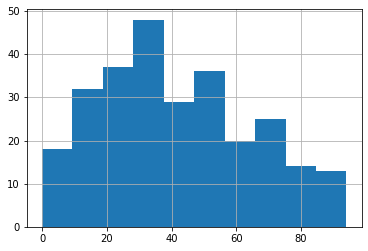

In [15]:
quantile_data.q_Bench.hist()